<a href="https://colab.research.google.com/github/dasdibye/DL4RegAlloc/blob/main/gadjseq2seq100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Imports

In [ ]:
! pip install spektral

     |████████████████████████████████| 112kB 6.7MB/s 


In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import csv
from __future__ import division
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
import sklearn.preprocessing as preprocessing
from random import randint
from numpy import array
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from spektral.layers import GCNConv, GlobalSumPool
from spektral.data.loaders import DisjointLoader
from spektral.data import Dataset
from spektral.utils import normalized_laplacian
from spektral.layers.ops import sp_matrix_to_sp_tensor
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Common APIs

In [ ]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    if ('val_categorical_accuracy' in history.history.keys()):
        plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    if ('val_loss' in history.history.keys()):
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def adBits(x, x2, y):
   for i in range(x.shape[0]):
      #print(' for each train sample  ... ', i)
      loop = seqsize
      j = 0
      for loop in range(seqsize):     
          #print(' for each node ... ', j)
          adBits_1 = int(x[i][2*loop])
          #Get the next LONG since each node now has 2 LONGs for adj edges
          adBits_2 = int(x[i][2*loop+1])
          # Uncomment below if you want invalid nodes to not feed to NN before any valid nodes
          #if (adBits_1==0 and adBits_1==0 and loop!=seqsize-1):              
          #    y[i][j] = y[i][loop+1] 
          #    continue
          if (adBits_1):
              #print adBits
              for k in range(0,64):
                  bit = adBits_1 & 1
                  #print ( ' adBits&1 = ',  bit )
                  # Uncomment below if you want new nodes to only have adjacency to earlier nodes
                  if ( bit == 1):
                  #if ( bit == 1 and k<j):
                      x2[i][j][k] = 1
                      #print x2[i-1][j-1][k-1]
                  else:
                      x2[i][j][k] = 0
                      #print x2[i-1][j-1][k-1]
                  adBits_1 >>= 1
              x2[i][j][j] = 1 

          if (adBits_2):   
              #print adBits
              for k in range(64,100):
                  bit = adBits_2 & 1
                  #print ( ' adBits&1 = ',  bit )
                  if ( bit == 1):
                  #if ( bit == 1 and k<j):
                      x2[i][j][k] = 1
                      #print x2[i-1][j-1][k-1]
                  else:
                      x2[i][j][k] = 0
                      #print x2[i-1][j-1][k-1]
                  adBits_2 >>= 1
              x2[i][j][j] = 1
          j = j+1
   return x2, y

In [ ]:
def updateLabelBits(x, y):
   for i in range(x.shape[0]):
      #print(' for each train sample  ... ', i)
      label_dict = {}
      label_num = 1
      for j in range(seqsize):
          if (x[i][j][j] == 0):
              y[i][j] = 0
          else:
              if y[i][j] in label_dict:
                  y[i][j] = label_dict[y[i][j]]
              else:
                  label_dict[y[i][j]] = label_num
                  y[i][j] = label_num
                  label_num = label_num + 1
   return y

In [ ]:
def post_process (x2_pred, predicted):
    #Calculate the number of edges which will require correction
    invCols = 0
    edges = 0
    for i in range(x2_pred.shape[0]):
        for j in range(seqsize):
            for k in range(j):
                adj = x2_pred[i][j][k]
                if ( adj == 1 ):
                    edges += 1
                    if ( np.argmax(predicted[i][j]) == np.argmax(predicted[i][k]) ) :
                        invCols += 1
                        
    print('Total No of edges ', edges)
    print('No of edges with invalid coloring ', invCols)
    print('Total percentage of edges with invalid colors ', invCols/edges)

In [ ]:
def post_process_chromatic (x2_pred, predicted):  
    invCols = 0
    edges = 0
    colors_list_list = []
    for i in range(x2_pred.shape[0]):
        colors_list = []
        for j in range(seqsize):
            #if (np.argmax(predicted[i][j]) != 0):
            #Valid nodes will have below set to 1 so check the color assignment of those nodes only
            if (x2_pred[i][j][j] != 0):
                colors_list.append(np.argmax(predicted[i][j]))
        print('Colors list of graph ', i, ' is  \n', colors_list)
        chromatic_number = len(set(colors_list))
        print('Chromatic number of graph ', i, ' is  ', chromatic_number)
        colors_list_list.append(colors_list)
    return colors_list_list

In [ ]:
csv_rows = []
def create_csv_rows (graph_name, colors_list_list_before_correction, colors_list_list_after_correction):    
    for i in range(len(colors_list_list_before_correction)):
        row = [graph_name, i, len(set(colors_list_list_before_correction[i])), len(set(colors_list_list_after_correction[i]))]        
        csv_rows.append(row)
    #print(csv_rows)    

In [ ]:
def post_process_correction (x2_pred, predicted, colors_list_list): 
  totInvCols = 0
  totEdges = 0

  for i in range(x2_pred.shape[0]):
      #maxcol = max(xpredicted[i])
      maxcol = max(colors_list_list[i])
      #print(maxcol)
      #mcol = maxcol[0]
      maxorigcol = maxcol
      mcolnew = maxcol
      #print('Maxcol = ',maxcol[0])
      #print(' ... FOR SAMPLE  ... ', i)
      invCols = 0
      edges = 0;
      newCol = 500

      for j in range(seqsize):
          #print(' ... ... FOR EACH NODE ... ...', j)
          for k in range(j):
              #print(' ... ... ... for each adjacency  ... ... ...', k)
              adj = x2_pred[i][j][k]
              #There is an edge
              if ( adj == 1 ):
                  edges += 1
                  if ( np.argmax(predicted[i][j]) == np.argmax(predicted[i][k]) ):                   
                      col_j = np.argmax(predicted[i][j])
                      col_k = np.argmax(predicted[i][k])
                      invCols += 1

                      #Check whether we can give one of the existing colors
                      foundfinalcol = 0
                      for  y in range(1,maxcol+1):
                          #print('Check for COLOR NO ... ', y)
                          if ( foundfinalcol == 1 ) :
                              #print('FOUND COLOR ALREADY  ... leave the loop')
                              break

                          foundcol = 0
                          #Check the adjacent nodes of j
                          #for  z in range(j):
                          for z in range(seqsize):
                              if j!=z:
                                  if  (   ((x2_pred[i][j][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                      or  ((x2_pred[i][z][j] == 1) and (np.argmax(predicted[i][z]) == y))
                                      ):
                                      #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                      foundcol = 1
                                      #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                      break

                          #Finished checking the adjacent nodes of j
                          #Color y is not used by any of j's neighbours
                          #print('[1] Finished Checking the adjacent node of ... ',j,' ... foundcol = ',foundcol)
                          if ( foundcol == 0 ) :
                              #assign any prediction > 1
                              predicted[i][j][y] = 2
                              #print('[1] Reuse color ', y, ' for node ', j)
                              foundfinalcol = 1

                          else :
                              foundcol = 0                                                            
                              #Check the adjacent nodes of k
                              for z in range(seqsize):
                                  if k!=z:
                                      if  (   ((x2_pred[i][k][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                          or  ((x2_pred[i][z][k] == 1) and (np.argmax(predicted[i][z]) == y))
                                          ):
                                          #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                          foundcol = 1
                                          #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                          break
                              #Color y is not used by any of k's neighbours
                              if ( foundcol == 0 ) :
                                  #assign any prediction > 1
                                  predicted[i][k][y] = 2
                                  #print('[2] Reuse color ', y, ' for node ', k )
                                  foundfinalcol = 1

                      # Could not color using an existing color
                      # Get a new color from 500 onwards OR use from the new 500 color number series
                      if ( foundfinalcol == 0 ) :
                           #newCol += 1
                           mcolnew += 1
                           #assign any prediction > 1
                           predicted[i][k][mcolnew] = 2
                           maxcol +=1
                           #print('Use new color ', mcolnew, ' for node ', k)

  #print('No of edges with invalid coloring while color correction is ON ', invCols)
  #totInvCols = totInvCols + invCols
  #print('No of edges ', edges)
  #totEdges = totEdges + edges
  #print('percentage of edges with invalid colors found by color correction algo', invCols/edges)

  #print('Ground truth cols = ',tncols[i][0])
  #print('Total colors predicted before compensation', maxorigcol )
  #print('Total colors predicted after compensation', mcolnew)
  #print('Extra colors', mcolnew - tncols[i][0])
  return predicted

## Read the data sets

In [ ]:
import glob
test_csvs = glob.glob('/content/drive/My Drive/Colab Notebooks/graph_csvs/*.csv')
#llvm_csvs = glob.glob('/content/drive/My Drive/Colab Notebooks/llvm_csvs/*.csv')
#llvm_result_csv = '/content/drive/My Drive/Colab Notebooks/llvm_csvs/llvm_results.csv'
#if llvm_result_csv in llvm_csvs:
#    llvm_csvs.remove(llvm_result_csv) 
#test_csvs = llvm_csvs
print(test_csvs)

[]


In [ ]:
#np.set_printoptions(threshold=np.inf)
seqsize = 100

test_csvs =["/content/drive/My Drive/Colab Notebooks/ntst100.csv", "/content/drive/My Drive/Colab Notebooks/baidu.csv", "/content/drive/My Drive/Colab Notebooks/gkarate.csv"]

eseq1 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/adjcols100.csv",header=None,low_memory=False)
eseq2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/tst100.csv",header=None,low_memory=False)
eseq  = pd.concat([eseq1, eseq2])
eseq  = eseq1

columns = eseq.columns.tolist()
#2 entries for each node's adjacency 
edata = eseq[columns[1:3*seqsize+1]]
#get the adj edges
edataadj = eseq[columns[1:2*seqsize+1]]
#get the colors
edatacols = eseq[columns[2*seqsize+1:3*seqsize+1]]
#chromatic number
ncols = eseq[columns[0:1]]

#Now make x_train a 2-dim array
#As we have read the adjacency row as bits
#and we now want to make them into features
#x_train and x2_train have different shapes as 2 LONGs are present in x_train
#So use y_train.shape[1] instead of x_train.shape[1]
#x2_train = np.zeros((x_train.shape[0],y_train.shape[1],128))
from keras.utils import to_categorical

x_train, y_train = np.array(edataadj), np.array(edatacols)
x2_train = np.zeros((x_train.shape[0], y_train.shape[1], seqsize))
x2_train, y_train = adBits(x_train, x2_train, y_train)
y_train = updateLabelBits(x2_train, y_train)
y2_train = to_categorical(y_train, num_classes=101)
print(x2_train.shape)
print(y2_train.shape)

x2_pred_list = []
y2_pred_list = []

for i,csv in enumerate(test_csvs):
    tseq = pd.read_csv(csv,header=None) 
    
    tstcolumns = list(tseq)
    
    tedataadj = tseq[tstcolumns[1:2*seqsize+1]]
    tedatacols = tseq[tstcolumns[2*seqsize+1:3*seqsize+1]]
    
    x_pred = np.array(tedataadj)
    y_pred = np.array(tedatacols)
    x2_pred = np.zeros((x_pred.shape[0],y_pred.shape[1],seqsize))
    x2_pred, y_pred = adBits(x_pred, x2_pred, y_pred)
    y_pred  = updateLabelBits(x2_pred, y_pred)
    y2_pred = to_categorical(y_pred, num_classes=101)

    x2_pred_list.append(list(x2_pred))
    y2_pred_list.append(list(y2_pred))

    print(np.asarray(x2_pred_list[i]).shape)
    print(np.asarray(y2_pred_list[i]).shape)   

(8158, 100, 100)
(8158, 100, 101)
(3237, 100, 100)
(3237, 100, 101)
(1, 100, 100)
(1, 100, 101)
(1, 100, 100)
(1, 100, 101)


In [ ]:
#y2_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))
#y2_pred = np.reshape(y_pred, (y_pred.shape[0],y_pred.shape[1],1))
print(y2_train.shape)
#print(y2_pred.shape)

(8158, 100, 101)


In [ ]:
# Train test split
#x2_train, x2_pred, y2_train, y2_pred = train_test_split(x2_train,y2_train,test_size=0.2,random_state=42,shuffle=True)
#print (x2_train.shape, x2_pred.shape, y2_train.shape, y2_pred.shape)

In [ ]:
print(x_train.shape, x_train[8000])

In [ ]:
a1 = np.reshape(x2_train, (x2_train.shape[0]*x2_train.shape[1], x2_train.shape[2]))
unique_nodes = len(np.unique(a1, axis=0))
print(unique_nodes)

331179


In [ ]:
x2_train_feature = np.sum(x2_train, axis=2, keepdims=True)
print(x2_train_feature.shape)


(8158, 100, 1)


In [ ]:
print(x2_train_feature[300][3][0])
print(x2_train[300][3])

## Models

### Graph Neural Network using Spektral

In [ ]:
# Parameters
channels = 16          # Number of channels in the first layer
dropout = 0.25         # Dropout rate for the features
l2_reg = 5e-4 / 2      # L2 regularization rate
learning_rate = 1e-2   # Learning rate
epochs = 100           # Number of training epochs
patience = 10          # Patience for early stopping
#a_dtype = dataset[0].a.dtype  # Only needed for TF 2.1
n_out = 100

# Model definition
# x_in = Input(shape=(100,))
# a_in = Input((100,), sparse=True)

# #do_1 = Dropout(dropout)(x_in)
# gc_1 = GCNConv(channels,
#                activation='relu',
#                kernel_regularizer=l2(l2_reg),
#                use_bias=False)([x_in, a_in])
# do_2 = Dropout(dropout)(gc_1)
# gc_2 = GCNConv(n_out,
#                activation='softmax',
#                use_bias=False)([do_2, a_in])

# # Build model
# model = Model(inputs=[x_in, a_in], outputs=gc_2)
# optimizer = Adam(lr=learning_rate)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.summary()

N = x2_train_feature[-2]
F = x2_train_feature[-1]
x_in = Input(shape=(100, 1))
a_in = Input(shape=(100, 100))
#a_in = Input((100,), sparse=True)
#x_in = Input(shape=(seqsize, seqsize))
#fltr = normalized_laplacian(x2_train)
#a_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))

#do_1 = Dropout(dropout)(x_in)
gc_1 = GCNConv(channels,
               activation='relu',
               kernel_regularizer=l2(l2_reg),
               use_bias=False)(x_in, a_in)
do_2 = Dropout(dropout)(gc_1)
gc_2 = GCNConv(n_out,
               activation='softmax',
               use_bias=False)([do_2, a_in])

# Build model
model = Model(inputs=[x_in, a_in], outputs=gc_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

TypeError: ignored

In [ ]:
# Train model

# Loader module to create batch even for graphs of different sizes
# loader_tr = DisjointLoader([x2_train, y2_train])
# loader_va = DisjointLoader([x2_pred, y2_pred])

history = model.fit(inputs=[x2_train_feature, x2_train],
                    epochs=epochs,
                    batch_size=64,
                    verbose=2)
                    #validation_data=(x2_pred, y2_pred))
                    #callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)])

TypeError: ignored

### 3 LSTM (512 Bi, 512, 512) with Attention

In [ ]:
#Use this Input format for direct input to LSTM

seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')
encoder = layers.Bidirectional(layers.LSTM(512, return_sequences=True, name="lstm_1"))(seq_inputs)
encoder = layers.Bidirectional(layers.LSTM(128, return_sequences=True, name="lstm_2"))(encoder)
activations = layers.Bidirectional(layers.LSTM(64, return_sequences=True, name="lstm_3"))(encoder)
print(activations.shape[2])

# Attention model
# compute importance for each step
attention = layers.Dense(activations.shape[2])(activations)
attention = layers.Activation('tanh')(attention)
attention = layers.Dense(1)(attention)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(activations.shape[2])(attention) # match the dimensions of LSTM activations
attention = layers.Permute([2, 1])(attention)

# apply the attention
context = layers.Multiply()([activations, attention]) # Multiply attentions vector with LSTM cell output
decoder_outputs = layers.TimeDistributed(layers.Dense(101, activation="softmax"))(context)

model = tf.keras.Model(inputs=seq_inputs, outputs=decoder_outputs)

In [ ]:
n_epoch=100
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(x2_pred, y2_pred))

### 3 LSTMs (Original-1024,1024,1024)

In [ ]:
#Use this Input format for direct input to LSTM

seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')

encoder = layers.LSTM(1024, return_sequences=True, name="lstm_1")(seq_inputs)
encoder = layers.LSTM(1024, return_sequences=True, name="lstm_2")(encoder)
decoder = layers.LSTM(1024, return_sequences=True, name="lstm_3")(encoder)

decoderoutputs = layers.TimeDistributed(layers.Dense(101,activation="softmax"))(decoder)

model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

In [ ]:
n_epoch=80
n_batch=64

#model.compile(optimizer="adam", loss="mean_absolute_percentage_error", metrics=['mean_absolute_percentage_error'])
#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 1024)         4608000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 1024)         8392704   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 1024)         8392704   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 100, 101)          103525    
Total params: 21,496,933
Trainable params: 21,496,933
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/80
248/248 - 64s - loss: 1.2336 - categorical_accuracy: 0.6316
Epoch 2/80
248/248 - 66s - loss: 0.8569 - categorical_accuracy: 0.6763
Epoch 3/80
248/248 - 67s - loss: 0.8189 - categorical_accuracy: 0.6818
Epoch 4/80
248/248 - 67s - loss: 0.7929 - categorical_accuracy: 0.6888
Epoch 5/80
248/248 - 67s - loss: 0.8038 - categorical_accuracy: 0.6891
Epoch 6/80
248/248 - 67s - loss: 0.7741 - categorical_accuracy: 0.6941
Epoch 7/80
248/248 - 67s - loss: 0.7634 - categorical_accuracy: 0.6966
Epoch 8/80
248/248 - 67s - loss: 0.7564 - categorical_accuracy: 0.6987
Epoch 9/80
248/248 - 67s - loss: 0.7499 - categorical_accuracy: 0.7003
Epoch 10/80
248/248 - 67s - loss: 0.7449 - categorical_accuracy: 0.7018
Epoch 11/80
248/248 - 67s - loss: 0.7415 - categorical_accuracy: 0.7025
Epoch 12/80
248/248 - 67s - loss: 0.7386 - categorical_accuracy: 0.7033
Epoch 13/80
248/248 - 67s - loss: 0.7349 - categorical_accuracy: 0.7038
Epoch 14/80
248/248 - 67s - loss: 0.7326 - categorical_accuracy: 0.7052
E

dict_keys(['loss', 'categorical_accuracy'])


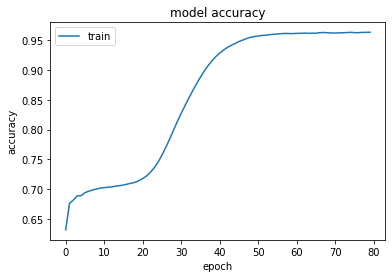

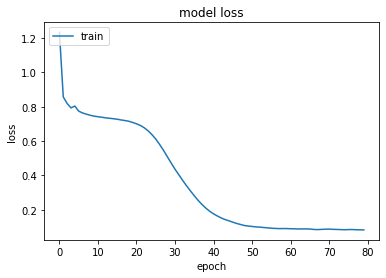

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/color1_new.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color1_new.h5")
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/ntst100.csv -------

Invalid edges percentage before color correction ->
Total No of edges  1502707
No of edges with invalid coloring  138632
Total percentage of edges with invalid colors  0.09225484409136311


------PREDICTING  /content/drive/My Drive/Colab Notebooks/baidu.csv -------

Invalid edges percentage before color correction ->
Total No of edges  91
No of edges with invalid coloring  34
Total percentage of edges with invalid colors  0.37362637362637363

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [1, 2, 2, 3, 4, 1, 3, 3, 2, 3, 2, 4, 4, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 4, 3, 1, 3, 2, 3, 3, 2, 2, 2, 2, 1, 3, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 1]
Chromatic number of graph  0  is   4

Apply color correction ->
Total colors predicted before compensation 4
Total colors predicted after compensation 4

Colors list and Chromatic number following color

### 3 LSTM (1024, 512, 256)

In [ ]:
#Use this Input format for direct input to LSTM
seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')

encoder = layers.LSTM(1024, return_sequences=True, name="lstm_1")(seq_inputs)
encoder = layers.LSTM(512, return_sequences=True, name="lstm_2")(encoder)
decoder = layers.LSTM(256, return_sequences=True, name="lstm_3")(encoder)
decoderoutputs = layers.TimeDistributed(layers.Dense(101,activation="softmax"))(decoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

In [ ]:
n_epoch=80
n_batch=64

#model.compile(optimizer="adam", loss="mean_absolute_percentage_error", metrics=['mean_absolute_percentage_error'])
#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 1024)         4608000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 512)          3147776   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 256)          787456    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 100, 101)          25957     
Total params: 8,569,189
Trainable params: 8,569,189
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/80
248/248 - 28s - loss: 1.2865 - categorical_accuracy: 0.6286
Epoch 2/80
248/248 - 29s - loss: 0.8635 - categorical_accuracy: 0.6765
Epoch 3/80
248/248 - 28s - loss: 0.8234 - categorical_accuracy: 0.6819
Epoch 4/80
248/248 - 29s - loss: 0.8027 - categorical_accuracy: 0.6870
Epoch 5/80
248/248 - 29s - loss: 0.7864 - categorical_accuracy: 0.6908
Epoch 6/80
248/248 - 29s - loss: 0.7772 - categorical_accuracy: 0.6936
Epoch 7/80
248/248 - 29s - loss: 0.7690 - categorical_accuracy: 0.6955
Epoch 8/80
248/248 - 29s - loss: 0.7621 - categorical_accuracy: 0.6974
Epoch 9/80
248/248 - 29s - loss: 0.7563 - categorical_accuracy: 0.6990
Epoch 10/80
248/248 - 29s - loss: 0.7527 - categorical_accuracy: 0.6999
Epoch 11/80
248/248 - 29s - loss: 0.7481 - categorical_accuracy: 0.7008
Epoch 12/80
248/248 - 29s - loss: 0.7461 - categorical_accuracy: 0.7015
Epoch 13/80
248/248 - 29s - loss: 0.7433 - categorical_accuracy: 0.7019
Epoch 14/80
248/248 - 29s - loss: 0.7409 - categorical_accuracy: 0.7028
E

dict_keys(['loss', 'categorical_accuracy'])


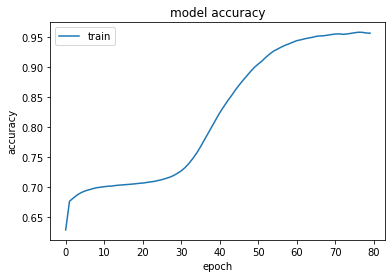

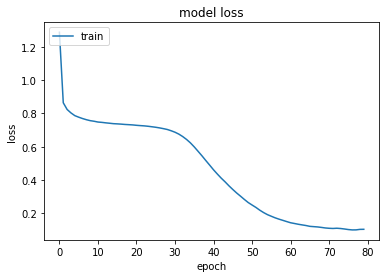

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/color2_new.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color2_new.h5")
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/ntst100.csv -------

Invalid edges percentage before color correction ->
Total No of edges  1502707
No of edges with invalid coloring  139241
Total percentage of edges with invalid colors  0.09266011271658414


------PREDICTING  /content/drive/My Drive/Colab Notebooks/baidu.csv -------

Invalid edges percentage before color correction ->
Total No of edges  91
No of edges with invalid coloring  33
Total percentage of edges with invalid colors  0.3626373626373626

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [1, 1, 2, 2, 3, 3, 1, 1, 2, 3, 3, 1, 1, 1, 2, 1, 2, 2, 3, 3, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 3, 1, 1, 2, 3]
Chromatic number of graph  0  is   3

Apply color correction ->
Total colors predicted before compensation 3
Total colors predicted after compensation 4

Colors list and Chromatic number following color 

### 3 LSTM (512 Bi, 256 Bi, 128 Bi)

In [ ]:
#Use this Input format for direct input to LSTM
seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')
encoder = layers.Bidirectional(layers.LSTM(512, return_sequences=True, name="lstm_1"))(seq_inputs)
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Bidirectional(layers.LSTM(256, return_sequences=True, name="lstm_2"))(encoder)
encoder = layers.Dropout(0.2)(encoder)
decoder = layers.Bidirectional(layers.LSTM(128, return_sequences=True, name="lstm_3"))(encoder)
decoder = layers.Dropout(0.2)(decoder)
decoderoutputs = layers.TimeDistributed(layers.Dense(101,activation="softmax"))(decoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

#model = Sequential()

# embedding layer
#model.add(Embedding(unique_nodes, 64, input_length=seqsize))

# lstm layers
#model.add(LSTM(512, return_sequences=True, name="lstm_1"))
#model.add(LSTM(256, return_sequences=True, name="lstm_2"))
#model.add(LSTM(128, return_sequences=True, name="lstm_3"))

# output layer
#model.add(layers.TimeDistributed(Dense(101, activation='softmax')))

In [ ]:
n_epoch=80
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 1024)         2510848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 1024)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 512)          2623488   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 256)          656384    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0   

In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/80
248/248 - 30s - loss: 0.9414 - categorical_accuracy: 0.6667
Epoch 2/80
248/248 - 24s - loss: 0.8060 - categorical_accuracy: 0.6852
Epoch 3/80
248/248 - 24s - loss: 0.7766 - categorical_accuracy: 0.6927
Epoch 4/80
248/248 - 24s - loss: 0.7592 - categorical_accuracy: 0.6971
Epoch 5/80
248/248 - 24s - loss: 0.7427 - categorical_accuracy: 0.7009
Epoch 6/80
248/248 - 24s - loss: 0.7316 - categorical_accuracy: 0.7037
Epoch 7/80
248/248 - 25s - loss: 0.7247 - categorical_accuracy: 0.7051
Epoch 8/80
248/248 - 25s - loss: 0.7195 - categorical_accuracy: 0.7067
Epoch 9/80
248/248 - 25s - loss: 0.7150 - categorical_accuracy: 0.7078
Epoch 10/80
248/248 - 25s - loss: 0.7109 - categorical_accuracy: 0.7086
Epoch 11/80
248/248 - 25s - loss: 0.7084 - categorical_accuracy: 0.7089
Epoch 12/80
248/248 - 25s - loss: 0.7057 - categorical_accuracy: 0.7094
Epoch 13/80
248/248 - 25s - loss: 0.7031 - categorical_accuracy: 0.7103
Epoch 14/80
248/248 - 25s - loss: 0.7011 - categorical_accuracy: 0.7107
E

dict_keys(['loss', 'categorical_accuracy'])


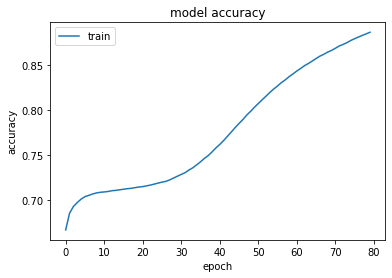

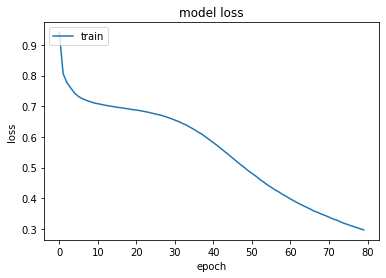

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
#model.save("/content/drive/My Drive/Colab Notebooks/color3_new.h5")

In [ ]:
#model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color3_new.h5")
csv_rows = []
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list_before_correction = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list_before_correction)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list_after_correction = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)
        create_csv_rows(csv.rsplit('/',1)[1], colors_list_list_before_correction, colors_list_list_after_correction)

import csv
with open(llvm_result_csv, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)      
    # writing the data rows
    csvwriter.writerows(csv_rows)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/llvm_csvs/xz.csv -------

Invalid edges percentage before color correction ->
Total No of edges  13806
No of edges with invalid coloring  1535
Total percentage of edges with invalid colors  0.11118354338693322

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [1, 2, 3, 4, 5, 1, 1, 1, 1, 2, 6, 7, 7, 4, 2, 4, 6, 2, 2, 1, 1, 1, 5, 5, 5, 2, 2, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 5, 1, 5]
Chromatic number of graph  0  is   7
Colors list of graph  1  is  
 [1, 2, 3, 4, 1, 5, 1, 1, 1, 5, 1, 1, 5, 5, 5, 5, 2, 2, 5, 2, 5, 5, 2, 5, 1, 1, 5, 1, 5, 5, 1, 5]
Chromatic number of graph  1  is   5
Colors list of graph  2  is  
 [1, 2, 3, 1, 4, 4, 5, 5, 4, 4, 4, 5, 5, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 3, 2, 1, 1, 3, 2]
Chromatic number of graph  2  is   5
Colors list of graph  3  is  
 [1, 2, 3, 3, 4, 5, 6, 7, 2, 8, 2, 9, 2, 6, 6, 3, 3, 3, 8, 2, 3]
Chromatic number of graph  3  is   9
Colors list of gr

### 3 LSTM (512 Bi, 128 Bi, 64 Bi)

In [ ]:
#Use this Input format for direct input to LSTM

seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')

encoder = layers.Bidirectional(layers.LSTM(512, return_sequences=True, name="lstm_1"))(seq_inputs)
encoder = layers.Bidirectional(layers.LSTM(128, return_sequences=True, name="lstm_2"))(encoder)
encoder = layers.Bidirectional(layers.LSTM(64, return_sequences=True, name="lstm_3"))(encoder)
decoderoutputs = layers.TimeDistributed(layers.Dense(101, activation="softmax"))(encoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

In [ ]:
n_epoch=90
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 1024)         2510848   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 256)          1180672   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 128)          164352    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 100, 101)          13029     
Total params: 3,868,901
Trainable params: 3,868,901
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/90
248/248 - 18s - loss: 0.9891 - categorical_accuracy: 0.6629
Epoch 2/90
248/248 - 18s - loss: 0.8575 - categorical_accuracy: 0.6758
Epoch 3/90
248/248 - 18s - loss: 0.8021 - categorical_accuracy: 0.6862
Epoch 4/90
248/248 - 18s - loss: 0.7823 - categorical_accuracy: 0.6918
Epoch 5/90
248/248 - 18s - loss: 0.7660 - categorical_accuracy: 0.6958
Epoch 6/90
248/248 - 18s - loss: 0.7563 - categorical_accuracy: 0.6985
Epoch 7/90
248/248 - 18s - loss: 0.7461 - categorical_accuracy: 0.7005
Epoch 8/90
248/248 - 18s - loss: 0.7366 - categorical_accuracy: 0.7035
Epoch 9/90
248/248 - 18s - loss: 0.7297 - categorical_accuracy: 0.7054
Epoch 10/90
248/248 - 18s - loss: 0.7239 - categorical_accuracy: 0.7068
Epoch 11/90
248/248 - 18s - loss: 0.7305 - categorical_accuracy: 0.7056
Epoch 12/90
248/248 - 18s - loss: 0.7180 - categorical_accuracy: 0.7081
Epoch 13/90
248/248 - 18s - loss: 0.7129 - categorical_accuracy: 0.7093
Epoch 14/90
248/248 - 18s - loss: 0.7096 - categorical_accuracy: 0.7100
E

dict_keys(['loss', 'categorical_accuracy'])


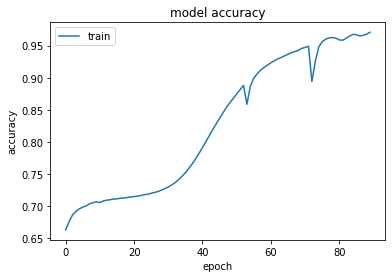

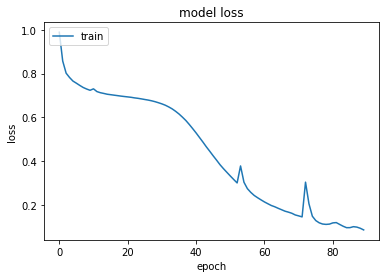

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/color4_new.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color4_new.h5")
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/ntst100.csv -------

Invalid edges percentage before color correction ->
Total No of edges  1502707
No of edges with invalid coloring  139789
Total percentage of edges with invalid colors  0.09302478793271077


------PREDICTING  /content/drive/My Drive/Colab Notebooks/baidu.csv -------

Invalid edges percentage before color correction ->
Total No of edges  91
No of edges with invalid coloring  34
Total percentage of edges with invalid colors  0.37362637362637363

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [1, 1, 2, 2, 1, 3, 1, 1, 2, 3, 3, 2, 1, 2, 1, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1, 3, 1, 2, 3, 3, 1, 2, 3, 3, 2, 3, 3, 2, 1, 2, 2, 2, 2, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 3, 1, 3, 1]
Chromatic number of graph  0  is   3

Apply color correction ->
Total colors predicted before compensation 3
Total colors predicted after compensation 4

Colors list and Chromatic number following color

### 3 LSTM (256 Bi, 256 Bi, 256 Bi - again)

In [ ]:
#Use this Input format for direct input to LSTM

seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')

encoder = layers.Bidirectional(layers.LSTM(256, return_sequences=True, name="lstm_1"))(seq_inputs)
encoder = layers.Bidirectional(layers.LSTM(256, return_sequences=True, name="lstm_2"))(encoder)
encoder = layers.Bidirectional(layers.LSTM(256, return_sequences=True, name="lstm_3"))(encoder)
decoderoutputs = layers.TimeDistributed(layers.Dense(101, activation="softmax"))(encoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

In [ ]:
n_epoch=90
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 512)          731136    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 512)          1574912   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 512)          1574912   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 101)          51813     
Total params: 3,932,773
Trainable params: 3,932,773
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/90
248/248 - 19s - loss: 0.9072 - categorical_accuracy: 0.6714
Epoch 2/90
248/248 - 19s - loss: 0.7924 - categorical_accuracy: 0.6868
Epoch 3/90
248/248 - 19s - loss: 0.7694 - categorical_accuracy: 0.6934
Epoch 4/90
248/248 - 19s - loss: 0.7508 - categorical_accuracy: 0.6989
Epoch 5/90
248/248 - 19s - loss: 0.7354 - categorical_accuracy: 0.7027
Epoch 6/90
248/248 - 19s - loss: 0.7272 - categorical_accuracy: 0.7049
Epoch 7/90
248/248 - 19s - loss: 0.7208 - categorical_accuracy: 0.7066
Epoch 8/90
248/248 - 19s - loss: 0.7155 - categorical_accuracy: 0.7080
Epoch 9/90
248/248 - 19s - loss: 0.7098 - categorical_accuracy: 0.7093
Epoch 10/90
248/248 - 19s - loss: 0.7056 - categorical_accuracy: 0.7101
Epoch 11/90
248/248 - 19s - loss: 0.7025 - categorical_accuracy: 0.7111
Epoch 12/90
248/248 - 19s - loss: 0.6992 - categorical_accuracy: 0.7118
Epoch 13/90
248/248 - 19s - loss: 0.6975 - categorical_accuracy: 0.7127
Epoch 14/90
248/248 - 19s - loss: 0.6957 - categorical_accuracy: 0.7131
E

dict_keys(['loss', 'categorical_accuracy'])


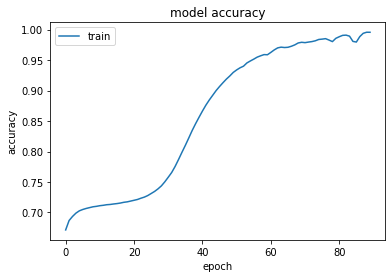

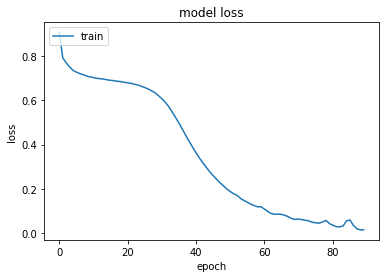

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/color5_new.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color5_new.h5")
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/ntst100.csv -------

Invalid edges percentage before color correction ->
Total No of edges  1502707
No of edges with invalid coloring  140489
Total percentage of edges with invalid colors  0.09349061393871194


------PREDICTING  /content/drive/My Drive/Colab Notebooks/baidu.csv -------

Invalid edges percentage before color correction ->
Total No of edges  91
No of edges with invalid coloring  29
Total percentage of edges with invalid colors  0.31868131868131866

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [1, 1, 2, 2, 3, 1, 1, 3, 3, 3, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 2, 1, 2, 1, 1, 3, 2, 3, 3, 3, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2]
Chromatic number of graph  0  is   3

Apply color correction ->
Total colors predicted before compensation 3
Total colors predicted after compensation 4

Colors list and Chromatic number following color

### 3 LSTM (1024 Bi, 512 Bi, 256 Bi - again)

In [ ]:
#Use this Input format for direct input to LSTM

seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')

encoder = layers.Bidirectional(layers.LSTM(1024, return_sequences=True, name="lstm_1"))(seq_inputs)
encoder = layers.Bidirectional(layers.LSTM(512, return_sequences=True, name="lstm_2"))(encoder)
encoder = layers.Bidirectional(layers.LSTM(256, return_sequences=True, name="lstm_3"))(encoder)
decoderoutputs = layers.TimeDistributed(layers.Dense(101, activation="softmax"))(encoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

In [ ]:
n_epoch=60
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 100, 100)]        0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 100, 2048)         9216000   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 100, 1024)         10489856  
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 100, 512)          2623488   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 100, 101)          51813     
Total params: 22,381,157
Trainable params: 22,381,157
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/60
248/248 - 72s - loss: 0.9342 - categorical_accuracy: 0.6686
Epoch 2/60
248/248 - 72s - loss: 0.8012 - categorical_accuracy: 0.6860
Epoch 3/60
248/248 - 72s - loss: 0.7724 - categorical_accuracy: 0.6935
Epoch 4/60
248/248 - 72s - loss: 0.7524 - categorical_accuracy: 0.6987
Epoch 5/60
248/248 - 73s - loss: 0.7339 - categorical_accuracy: 0.7035
Epoch 6/60
248/248 - 72s - loss: 0.7198 - categorical_accuracy: 0.7068
Epoch 7/60
248/248 - 72s - loss: 0.7127 - categorical_accuracy: 0.7081
Epoch 8/60
248/248 - 72s - loss: 0.7081 - categorical_accuracy: 0.7096
Epoch 9/60
248/248 - 72s - loss: 0.7030 - categorical_accuracy: 0.7109
Epoch 10/60
248/248 - 72s - loss: 0.7050 - categorical_accuracy: 0.7102
Epoch 11/60
248/248 - 72s - loss: 0.6977 - categorical_accuracy: 0.7124
Epoch 12/60
248/248 - 72s - loss: 0.6941 - categorical_accuracy: 0.7133
Epoch 13/60
248/248 - 72s - loss: 0.6912 - categorical_accuracy: 0.7146
Epoch 14/60
248/248 - 72s - loss: 0.6892 - categorical_accuracy: 0.7156
E

dict_keys(['loss', 'categorical_accuracy'])


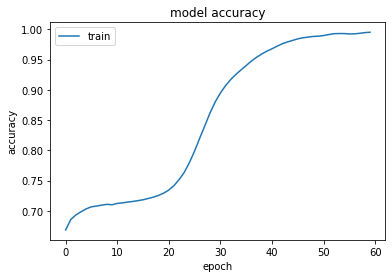

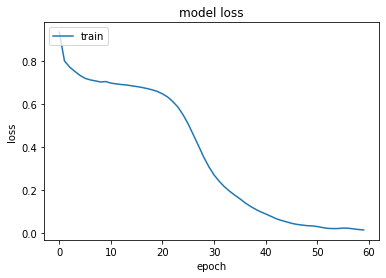

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/color6_new.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color6_new.h5")
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/graph_csvs/ntst100.csv -------

Invalid edges percentage before color correction ->
Total No of edges  1502707
No of edges with invalid coloring  109328
Total percentage of edges with invalid colors  0.07275403654870843


------PREDICTING  /content/drive/My Drive/Colab Notebooks/graph_csvs/queens6.csv -------

Invalid edges percentage before color correction ->
Total No of edges  290
No of edges with invalid coloring  40
Total percentage of edges with invalid colors  0.13793103448275862

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [2, 3, 3, 4, 5, 6, 4, 1, 7, 2, 2, 5, 7, 6, 3, 2, 6, 2, 3, 6, 6, 7, 2, 6, 6, 1, 5, 4, 6, 1, 7, 7, 3, 4, 5, 5]
Chromatic number of graph  0  is   7

Apply color correction ->
Total colors predicted before compensation 7
Total colors predicted after compensation 11

Colors list and Chromatic number following color correction ->
Colors list of graph  0  is  
 

### LSTM + Conv 1D

In [ ]:
#Use this Input format for direct input to LSTM
seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')

# Initially start with 2 or 3 and then increase it
# Add more layers of conv 1D
encoder = layers.Conv1D(64, 2, activation='relu')(seq_inputs)
encoder = layers.Conv1D(128, 4, activation='relu')(encoder)
encoder = layers.Conv1D(256, 8, activation='relu')(encoder)
encoder = layers.Bidirectional(layers.LSTM(512, return_sequences=True, name="lstm_1"))(encoder)
encoder = layers.Bidirectional(layers.LSTM(256, name="lstm_2"))(encoder)
encoder = layers.RepeatVector(100)(encoder)

decoderoutputs = layers.TimeDistributed(layers.Dense(101,activation="softmax"))(encoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

In [ ]:
n_epoch=90
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 99, 64)            12864     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 96, 128)           32896     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 89, 256)           262400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 89, 1024)          3149824   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               2623488   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 100, 512)         

In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/90
128/128 - 11s - loss: 1.6034 - categorical_accuracy: 0.5678
Epoch 2/90
128/128 - 11s - loss: 1.4540 - categorical_accuracy: 0.5734
Epoch 3/90
128/128 - 11s - loss: 1.4378 - categorical_accuracy: 0.5736
Epoch 4/90
128/128 - 11s - loss: 1.4332 - categorical_accuracy: 0.5734
Epoch 5/90
128/128 - 11s - loss: 1.4289 - categorical_accuracy: 0.5738
Epoch 6/90
128/128 - 11s - loss: 1.4290 - categorical_accuracy: 0.5738
Epoch 7/90
128/128 - 11s - loss: 1.4233 - categorical_accuracy: 0.5736
Epoch 8/90
128/128 - 11s - loss: 1.4206 - categorical_accuracy: 0.5737
Epoch 9/90
128/128 - 11s - loss: 1.4198 - categorical_accuracy: 0.5738
Epoch 10/90
128/128 - 11s - loss: 1.4209 - categorical_accuracy: 0.5737
Epoch 11/90
128/128 - 11s - loss: 1.4185 - categorical_accuracy: 0.5738
Epoch 12/90
128/128 - 11s - loss: 1.4182 - categorical_accuracy: 0.5738
Epoch 13/90
128/128 - 11s - loss: 1.4179 - categorical_accuracy: 0.5739
Epoch 14/90
128/128 - 11s - loss: 1.4176 - categorical_accuracy: 0.5738
E

dict_keys(['loss', 'categorical_accuracy'])


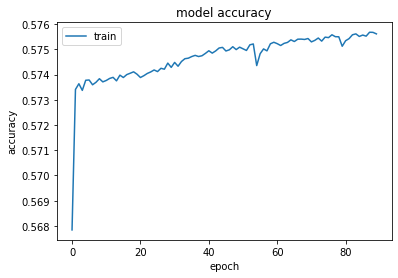

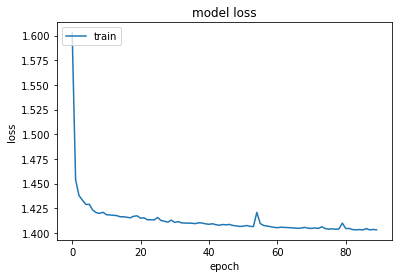

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
#model.save("/content/drive/My Drive/Colab Notebooks/color7_new.h5")

In [ ]:
#model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color7_new.h5")
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/graph_csvs/ntst100.csv -------

Invalid edges percentage before color correction ->
Total No of edges  1502707
No of edges with invalid coloring  1502707
Total percentage of edges with invalid colors  1.0


------PREDICTING  /content/drive/My Drive/Colab Notebooks/graph_csvs/queens6.csv -------

Invalid edges percentage before color correction ->
Total No of edges  290
No of edges with invalid coloring  290
Total percentage of edges with invalid colors  1.0

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Chromatic number of graph  0  is   1

Apply color correction ->
Total colors predicted before compensation 0
Total colors predicted after compensation 9

Colors list and Chromatic number following color correction ->
Colors list of graph  0  is  
 [1, 2, 3, 4, 5, 6, 3, 4, 1, 2, 

### LSTM + Conv 1D

In [ ]:
#Use this Input format for direct input to LSTM
seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')

# Initially start with 2 or 3 and then increase it
# Add more layers of conv 1D
encoder = layers.Conv1D(128, 2, activation='relu')(seq_inputs)
encoder = layers.Conv1D(256, 4, activation='relu')(encoder)
encoder = layers.Conv1D(512, 8, activation='relu')(encoder)
encoder = layers.Bidirectional(layers.LSTM(512, return_sequences=True, name="lstm_1"))(encoder)
encoder = layers.Bidirectional(layers.LSTM(256, name="lstm_2"))(encoder)
encoder = layers.RepeatVector(100)(encoder)

decoderoutputs = layers.TimeDistributed(layers.Dense(101,activation="softmax"))(encoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

In [ ]:
n_epoch=90
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 99, 128)           25728     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 96, 256)           131328    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 89, 512)           1049088   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 89, 1024)          4198400   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               2623488   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 100, 512)         

In [ ]:
#history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True, validation_data=(X_test, y_test))
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/90
128/128 - 13s - loss: 1.6523 - categorical_accuracy: 0.5635
Epoch 2/90
128/128 - 13s - loss: 1.4582 - categorical_accuracy: 0.5734
Epoch 3/90
128/128 - 13s - loss: 1.4346 - categorical_accuracy: 0.5739
Epoch 4/90
128/128 - 13s - loss: 1.4268 - categorical_accuracy: 0.5736
Epoch 5/90
128/128 - 13s - loss: 1.4232 - categorical_accuracy: 0.5739
Epoch 6/90
128/128 - 13s - loss: 1.4310 - categorical_accuracy: 0.5737
Epoch 7/90
128/128 - 13s - loss: 1.4354 - categorical_accuracy: 0.5736
Epoch 8/90
128/128 - 13s - loss: 1.4249 - categorical_accuracy: 0.5737
Epoch 9/90
128/128 - 13s - loss: 1.4205 - categorical_accuracy: 0.5738
Epoch 10/90
128/128 - 13s - loss: 1.4184 - categorical_accuracy: 0.5737
Epoch 11/90
128/128 - 13s - loss: 1.4204 - categorical_accuracy: 0.5737
Epoch 12/90
128/128 - 13s - loss: 1.4212 - categorical_accuracy: 0.5740
Epoch 13/90
128/128 - 13s - loss: 1.4385 - categorical_accuracy: 0.5738
Epoch 14/90
128/128 - 13s - loss: 1.4266 - categorical_accuracy: 0.5740
E

dict_keys(['loss', 'categorical_accuracy'])


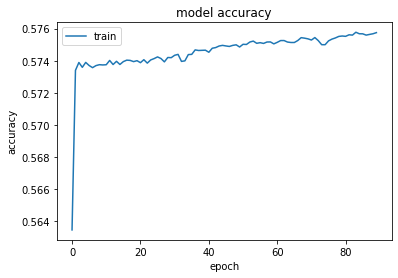

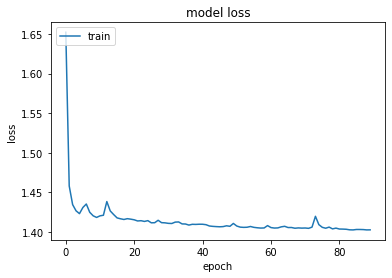

In [ ]:
plot_loss_accuracy(history)

#### Post Processing

In [ ]:
#model.save("/content/drive/My Drive/Colab Notebooks/color7_new.h5")

In [ ]:
#model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/color7_new.h5")
for i,csv in enumerate(test_csvs):
    print('\n------PREDICTING ',csv,'-------')
    predicted = model.predict(np.asarray(x2_pred_list[i]), batch_size=None, verbose=0, steps=None, callbacks=None)        
    print('\nInvalid edges percentage before color correction ->')
    post_process (np.asarray(x2_pred_list[i]), predicted)
    if ("ntst100.csv" in csv):
        print('')
    else:
        print('\nColors list and Chromatic number predicted by the model ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nApply color correction ->')
        predicted = post_process_correction(np.asarray(x2_pred_list[i]), predicted, colors_list_list)
        print('\nColors list and Chromatic number following color correction ->')
        colors_list_list = post_process_chromatic(np.asarray(x2_pred_list[i]), predicted)
        print('\nInvalid edges percentage after color correction ->')
        post_process (np.asarray(x2_pred_list[i]), predicted)


------PREDICTING  /content/drive/My Drive/Colab Notebooks/graph_csvs/ntst100.csv -------

Invalid edges percentage before color correction ->
Total No of edges  1502707
No of edges with invalid coloring  1502707
Total percentage of edges with invalid colors  1.0


------PREDICTING  /content/drive/My Drive/Colab Notebooks/graph_csvs/queens6.csv -------

Invalid edges percentage before color correction ->
Total No of edges  290
No of edges with invalid coloring  290
Total percentage of edges with invalid colors  1.0

Colors list and Chromatic number predicted by the model ->
Colors list of graph  0  is  
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Chromatic number of graph  0  is   1

Apply color correction ->
Total colors predicted before compensation 0
Total colors predicted after compensation 9

Colors list and Chromatic number following color correction ->
Colors list of graph  0  is  
 [1, 2, 3, 4, 5, 6, 3, 4, 1, 2, 